## Onderzoeksvraag

Bestaat er een invloed tussen de activiteit rond Bitcoin op Twitter en de prijs van twitter? Zo ja, hoe groot is deze impact?

Hiervoor zullen we het sentiment analyseren van elke tweet
	- algemeen sentiment
	- sentiment binnen een bepaalde periode (per maand mss?)

Ook de activiteit van tweets binnen een bepaalde periode
	

In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import *
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import re
import datetime
from typing import List
import numpy as np
from wordcloud import WordCloud
import folium
from PIL import Image
import yfinance as yf
from geopy.geocoders import Nominatim
from pattern.en import sentiment
from pyspark.sql import functions as F
from pyspark.sql.functions import col, desc, asc, udf, max

sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)
plt.style.use('ggplot')

21/12/06 14:54:20 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 172.16.167.94 instead (on interface wlp59s0)
21/12/06 14:54:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/12/06 14:54:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/12/06 14:54:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Data Exploration

### BITCOIN

 - Unix Timestamp - Date represented as epoc value
 - Date - date and time when the data point was collected
 - Symbol - Symbol of the currency
 - Open - Open value of the currency
 - High - Highest value of currency in the given minute
 - Low - Lowest value of currency in the given minute
 - Close - Close value of the currency in the given minute
 - Volume - Volume of the currency transacted in the given minute.

### TWITTER

 - user_name    The name of the user, as they’ve defined it.
 - user_location    The user-defined location for this account’s profile.
 - user_description	The user-defined UTF-8 string describing their account.
 - user_created	Time and date, when the account was created.
 - user_followers	The number of followers an account currently has.
 - user_friends	The number of friends a account currently has.
 - user_favourites	The number of favorites a account currently has
 - user_verified    When true, indicates that the user has a verified account
 - date UTC time and date when the Tweet was created
 - text The actual UTF-8 text of the Tweet
 - hashtags	All the other hashtags posted in the tweet along with #Bitcoin & #btc
 - source   Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
 - is_retweet	Indicates whether this Tweet has been Retweeted by the authenticating user.

# Tweets

We load tweet data from a dataset found on kaggle. A link to this dataset can be found in the README, provided in our *[github repository](https://github.com/snenenenenenene/btc-twitter-data-mining)*

In [2]:
tweets_schema = StructType([
    StructField('user_name', StringType(), True),
    StructField('user_location', StringType(), True),
    StructField('user_description', StringType(), True),
    StructField('user_created', StringType(), True),
    StructField('user_followers', FloatType(), True),
    StructField('user_friends', FloatType(), True),
    StructField('user_favourites', FloatType(), True),
    StructField('user_verified', BooleanType(), True),
    StructField('date', StringType(), True),
    StructField('text', StringType(), True),
    StructField('hashtags', StringType(), True),
    StructField('source', StringType(), True),
    StructField('is_retweet', BooleanType(), True),
])

tweets_df = spark.read.csv(
    "./data/tweets.csv",
    header=True,
    sep=',',
    multiLine=True,
    unescapedQuoteHandling="STOP_AT_CLOSING_QUOTE",
    schema=tweets_schema
)


In [3]:
tweets_df.show()

+--------------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+--------------------+----------+
|           user_name|  user_location|    user_description|       user_created|user_followers|user_friends|user_favourites|user_verified|               date|                text|            hashtags|              source|is_retweet|
+--------------------+---------------+--------------------+-------------------+--------------+------------+---------------+-------------+-------------------+--------------------+--------------------+--------------------+----------+
|       DeSota Wilson|    Atlanta, GA|Biz Consultant, r...|2009-04-26 20:05:09|        8534.0|      7605.0|         4838.0|        false|2021-02-10 23:59:04|Blue Ridge Bank s...|         ['bitcoin']|     Twitter Web App|     false|
|            CryptoND|           null|😎 BITCOINLIVE is...|2019-10-17 20:

## Utilities

In [4]:
def get_column_as_list(df, colname):
	return list(map(lambda r: (r[colname]), df.select(colname).collect()))

### Yahoo finance data

Now we will load the bitcoin financial data from yahoo finance using a python library. 

In [5]:
btc_stock = yf.Ticker("BTC-USD")
end = datetime.datetime(2021, 11, 26)
start = datetime.datetime(2021, 2, 5)

btc_stock = btc_stock.history(start=start, end=end)
btc_df = spark.createDataFrame(btc_stock)


## TWITTER

### Null values

Our dataset - now correctly loaded - shows that the amount of null values in the dataset is quite low. Except for the locations of users. This, however, is not due to a poor dataset, but due to these users not being willing to share their locations. Which should of course be respected and tolerated. Thus, there will be no actions taken to fill this data.  
The red line indicates the total amount of rows present in our dataset.

# Bitcoin & Twitter

Project on Data Mining by Bontenakel Lenny & Bels Senne.  
 *[Link to our github repository](https://github.com/snenenenenenene/btc-twitter-data-mining)*

# Bitcoin & Twitter

Project on Data Mining by Bontenakel Lenny & Bels Senne.  
 *[Link to our github repository](https://github.com/snenenenenenene/btc-twitter-data-mining)*

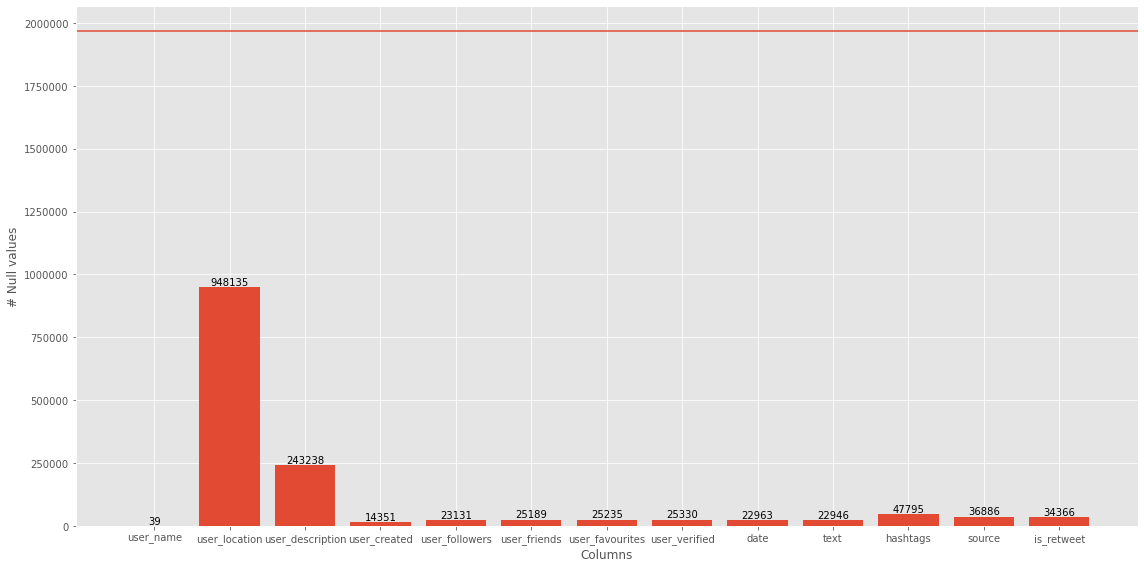

In [6]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.axhline(y=tweets_df.count(), label="Total amount of rows")
ax.bar_label(
    ax.bar(
        tweets_df.columns,
        [tweets_df.where(col(l).isNull()).count() for l in tweets_df.columns]
    )
)

ax.set_xlabel("Columns")
ax.set_ylabel("# Null values")

ax.ticklabel_format(axis='y', style='plain')
fig.tight_layout()
plt.show()

## Preparing Data

In [7]:
def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)


conv_to_int_udf = udf(lambda x: conv_to_int(x), IntegerType())

# tweets_df = tweets_df.withColumn("user_followers", conv_to_int_udf(col("user_followers")))\
#     .withColumn("user_friends", conv_to_int_udf(col("user_friends")))\
#     .withColumn("user_favourites", conv_to_int_udf(col("user_favourites")))

### Text cleaning

In [8]:
def clean_text(text):
    if (isinstance(text, str)):
        text = text.replace("#", "")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""
clean_text_udf = udf(lambda x: clean_text(x), StringType())



tweets_df = tweets_df.withColumn("text", clean_text_udf(col("text"))).dropna(subset=["user_name"])

## Generating impact score

### Fixing the hashtags array column 
Before we can generate the impact score, we need to generate an array of strings. This array represents the hashtags present within the tweet.
Since the csv format - which we use to read in the data - does not support arrays in pyspark. We need to fix it after reading it in as a string.

In [9]:
def fix_hashtags_array(hashtags_arr_string):
    try:
        closing_bracket = hashtags_arr_string.index(']', 1)
        subject = hashtags_arr_string[1 :closing_bracket]

        result = subject.split(', ') if closing_bracket > 1 else []
        result = ' '.join(result).replace("'", "").split()

        return result
        
    except ValueError:
        return []
    
fix_hashtags_array_udf = udf(lambda x: fix_hashtags_array(x), ArrayType(StringType()))

tweets_df = tweets_df.fillna("[]", subset="hashtags").withColumn("hashtags", fix_hashtags_array_udf(col("hashtags")))

Now that is done. We can use this array to generate an impact score for every tweet.

In [10]:
from pyspark.sql.functions import struct


def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1 + (len(tweet.hashtags) / 20)
    return ((tweet.user_followers + (tweet.user_friends / 4)) * coef_verified * coef_hashtags) / 100
    
generate_impact_score_udf = udf(lambda x: generate_impact_score(x), FloatType())

tweets_df = tweets_df.withColumn("impact_score", generate_impact_score_udf(struct([tweets_df[x] for x in tweets_df.columns])))

# Generating Date Dataframe


In [11]:
date_df = tweets_df.withColumn("date", F.to_date(F.col("date")))
date_df = date_df.groupby("date").count().dropna().sort(asc("date")).filter(
    (date_df.date > datetime.datetime(2020, 3, 20)) & (date_df.date < datetime.datetime.today()))

counts_df = date_df

def _get_next_dates(start_date: datetime.date, diff: int) -> List[datetime.date]:
    return [start_date + datetime.timedelta(days=days) for days in range(1, diff)]

def _get_fill_dates_df(df: DataFrame, date_column: str, group_columns: List[str], fill_column: str) -> DataFrame:
    get_next_dates_udf = udf(_get_next_dates, ArrayType(DateType()))

    window = Window.orderBy(*group_columns, date_column)

    return df.withColumn("_diff", F.datediff(F.lead(date_column, 1).over(window), date_column)).filter(col("_diff") > 1).withColumn("_next_dates", get_next_dates_udf(date_column, "_diff")).withColumn(fill_column, F.lit('')).withColumn(date_column, F.explode("_next_dates")).drop("_diff", "_next_dates")

fill_df = _get_fill_dates_df(date_df, "date",[], "count")
date_df = date_df.union(fill_df).sort(asc(col("date")))

### Twitter

### Most popular users
We will start separating data from the main dataframe, to create a new dataframe showing data about the used accounts.
This way we can easily show what accounts are most followed and loved.
However, user accounts are constantly changing. The amounts of followers, friends and favourites an accounts has rarely remains the same for long.
These values rise and fall, therefore it would not be wise to simply select the instance with the max amount of followers.

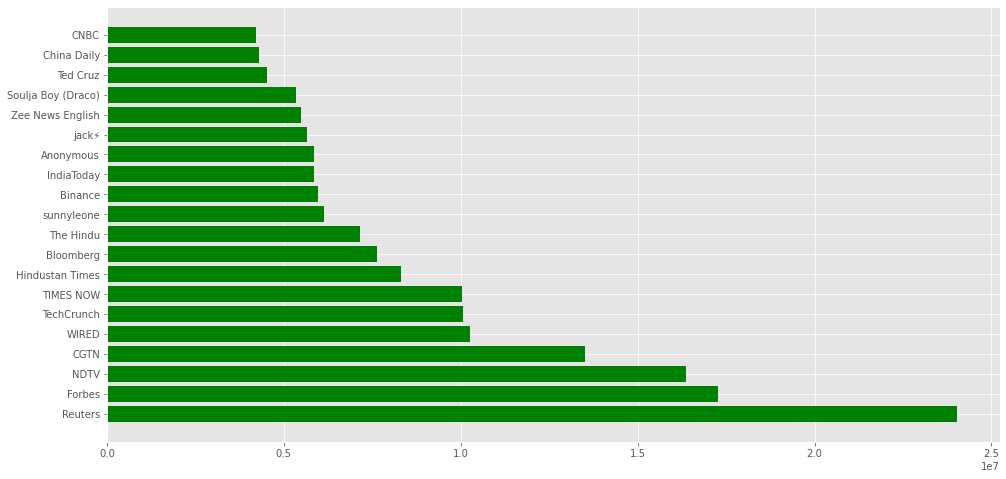

In [12]:
accounts_df = tweets_df.groupBy('user_name').max('user_followers').withColumnRenamed('max(user_followers)', 'user_followers').sort(desc('user_followers'))

x_rows = accounts_df.select('user_name').collect()
y_rows = accounts_df.select('user_followers').collect()

fig, ax = plt.subplots(figsize=(16, 8))

n = 20
ax.barh(
    [x.user_name for x in x_rows[:n]],
    [y.user_followers for y in y_rows[:n]],
    color='green',
    label='tweets/ user'
)

# ax.ticklabel_format(axis='x', style='plain')
plt.show()

## Where is Elon Musk?

In [13]:
# tweets_df.where(tweets_df.user_name == "Elon Musk").show()
# tweets_df.where(tweets_df.user_name == "Reuters").show()

### Tweets / user

Text(0, 0.5, 'username')

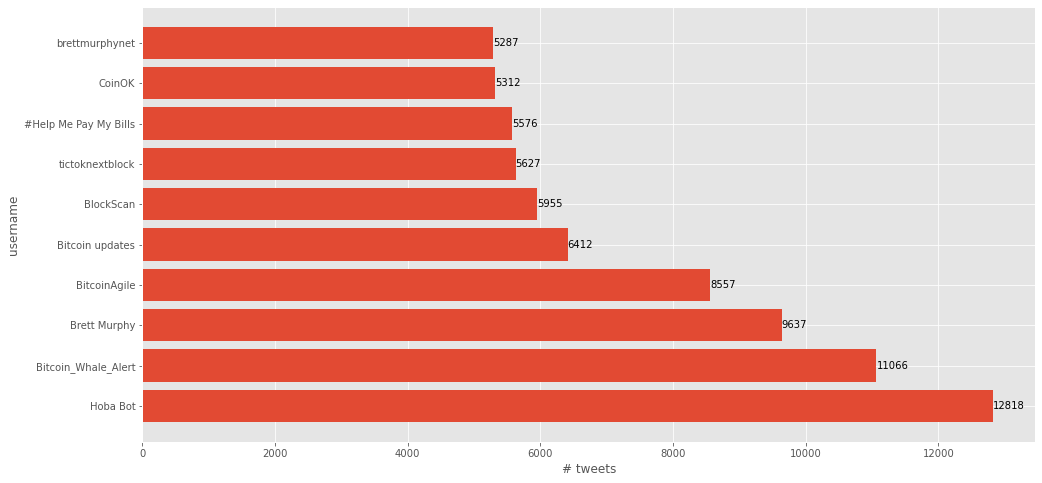

In [14]:
%matplotlib inline

user_volume = tweets_df.groupby("user_name").count().withColumnRenamed("count", "user_count").sort(desc("user_count"))

n = 10
x_rows = user_volume.limit(n).select("user_name").collect()
y_rows = user_volume.limit(n).select("user_count").collect()

fig, ax = plt.subplots(figsize=(16, 8))

ax.bar_label(
    ax.barh([x.user_name for x in x_rows],
           [y.user_count for y in y_rows],
           label='tweets/ user')
)

ax.set_xlabel('# tweets')
ax.set_ylabel('username')

### Bitcoin Value

In [15]:
# df_location = tweets_df.groupBy('user_location').count().sort(col("count").desc()).show()
geolocator = Nominatim(user_agent="example")
location_df = tweets_df.groupBy('user_location').count().filter("count >= 500").where(
    "user_location not in ('Decentralized', 'Moon', '🇦🇺', 'Everywhere', 'Road Warrior', 'Mars', 'Cloud Engineer', 'Planet Earth', 'Earth', 'Blockchain', 'The Blockchain')").sort(
    col("count").desc()).dropna().collect()


def coords(location_string):
    try:
        location_obj = geolocator.geocode(location_string).raw
        return (location_obj['lat'], location_obj['lon'])
    except:
        return (20, 20)


locations = list(map(lambda r: [r['user_location'], r['count'], coords(r['user_location'])], location_df))
map_tweets = folium.Map(location=[51,10], zoom_start=2)

for location_name, count, location_coords in locations:
    folium.Circle(location=location_coords,
                  popup=f"{location_name}: {count}",
                  radius=count * 50,
                  color="crimson",
                  fill_color="crimson",
                  tooltip=count).add_to(map_tweets)
map_tweets

21/12/06 14:58:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


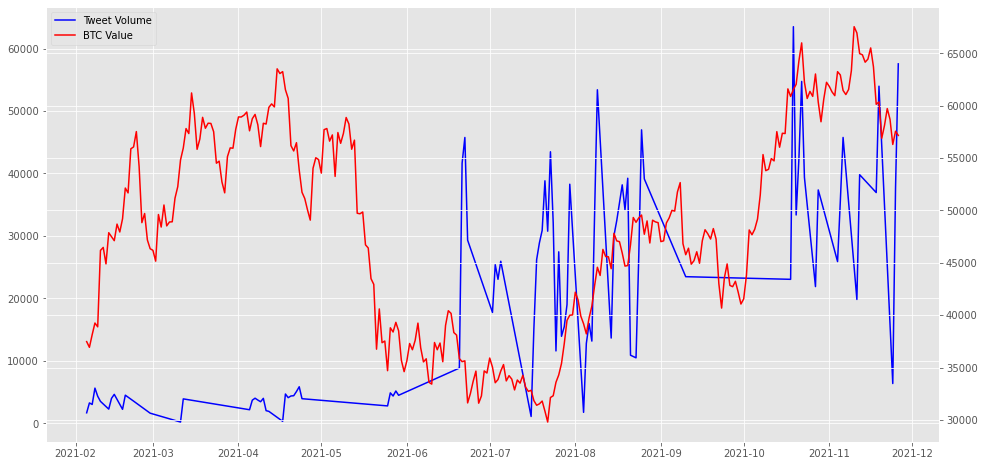

In [16]:
# X FOR BTC VOLUME
dates = date_df.select("date").collect()
x = list(map(lambda r: (r['date']), dates))

# X FOR COUNTS
counts_dates = counts_df.select("date").collect()
counts_x = list(map(lambda r: (r['date']), counts_dates))

# Y/COUNT OF TWEETS
y_rows = counts_df.select("count").collect()
tweets_y = list(map(lambda r: r['count'], y_rows))

# Y FOR BTC VOLUME
y_rows = btc_df.select("Open").collect()
btc_y = list(map(lambda r: float(r['Open']), y_rows))

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(counts_dates, tweets_y, color='blue', label='Tweet Volume')
# ax.set_yscale('log')
ax.tick_params(axis='y')

ax2 = ax.twinx()
ax2.plot(x,btc_y, color='red', label='BTC Value')
# ax2.set_yscale('log')
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2 , labels + labels2, loc=0)
plt.show()


## Sentiment Analysis

Here we will analyse the sentiments.....

In [17]:
tweet_text = tweets_df.select("text").limit(9999).collect()
sentiments = [(x.text, *sentiment(x.text)) for x in tweet_text]

sentiment_schema = ["text", "polarity", "subjectivity"]
sentiments_df = spark.createDataFrame(
    data=sentiments,
    schema=sentiment_schema
)

sentiments_df.show()

Traceback (most recent call last):
  File "/home/lenny/.local/share/miniconda3/envs/data-mining/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/home/lenny/.local/share/miniconda3/envs/data-mining/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/home/lenny/.local/share/miniconda3/envs/data-mining/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 643, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/home/lenny/.local/share/miniconda3/envs/data-mining/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 564, in read_int
    raise EOFError
EOFError


+--------------------+--------+------------------+
|                text|polarity|      subjectivity|
+--------------------+--------+------------------+
|Blue Ridge Bank s...|     0.0|               0.1|
|😎 Today, that's ...|     0.5|               1.0|
|Guys evening, I h...|     0.0|               0.0|
|$BTC A big chance...|     0.0|               0.1|
|This network is s...|     0.0|               0.1|
|💹 Trade Crypto o...|     0.4|               0.5|
|&lt;'fire' &amp; ...|     0.0|               0.0|
|🔄 Prices update ...|     0.0|               0.0|
|BTC Bitcoin Ether...|     0.0|               0.0|
|.@Tesla’s bitcoin...| -0.0625|              0.25|
|Annnd btc Bitcoin...|    0.25|               0.5|
|🔄 Prices update ...|     0.0|               0.0|
|Join our first vi...|    0.25|0.3333333333333333|
|Bitcoin BTC $BTC ...|     0.0|               0.0|
|⬆️⬆️ $BTC BUYING ...|     0.0|               0.0|
|Buy Bitcoin with ...|     0.0|               0.0|
|@naval BTC is unc...|     0.0|    

21/12/06 14:58:44 WARN TaskSetManager: Stage 71 contains a task of very large size (1211 KiB). The maximum recommended task size is 1000 KiB.


For the sake of not cluttering the chart with futile words such as 'a', 'in' or 'and' we left out the aforementioned ones as well as a short - yet cherry-picked - list of others.

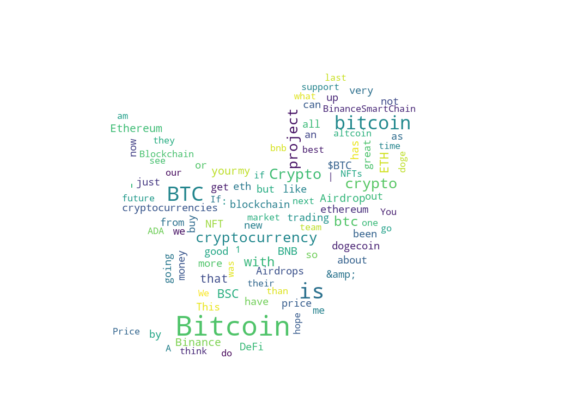

In [18]:
word_occurance = tweets_df.withColumn('word', F.explode(F.split(F.col('text'), ' '))).groupBy('word').count().sort('count', ascending=False).where(
    "word not in (' ', '', 'the', 'a', 'to', 'and', 'a', 'in', 'of', 'for', 'you', 'will', 'be', 'on', 'this', 'i', 'The', 'are', 'at', 'it', 'I')").limit(100)

twitter_mask = np.array(Image.open('twitter.jpeg'))
freqs = {r.asDict()['word'] : r.asDict()['count'] for r in word_occurance.collect()}
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", mask=twitter_mask).generate_from_frequencies(freqs)
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:
# hashtags_occurance = tweets_df.withColumn('hashtag', F.explode(col('hashtags'))).groupBy('hashtag').count().sort('count', ascending=False).limit(20)

hashtags_occurance = tweets_df.select("hashtags").withColumn("hashtag", F.explode(col('hashtags'))).groupBy('hashtag').count().sort(desc('count')).limit(20)

x = get_column_as_list(hashtags_occurance, "hashtag")
y = get_column_as_list(hashtags_occurance, "count")

plt.subplots(figsize=(16, 8))
plt.barh(x,y, color='orange', label='Volume')
plt.show()